In [12]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.translate import bleu_score
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm_notebook

from helper import Helper as H
from nmt_dataset import NMTDataset
from nmt_model import NMTModel
from nmt_sampler import NMTSampler

In [13]:

args = Namespace(dataset_csv="../Data/simplest_eng_fra.csv",
                 vectorizer_file="eng-fra-vectorizer.json",
                 model_state_file="eng-fra-model.pth",
                 save_dir="model/",
                 reload_from_files=False,
                 expand_filepaths_to_save_dir=True,
                 cuda=True,
                 seed=1337,
                 learning_rate=5e-4,
                 batch_size=64,
                 num_epochs=100,
                 early_stopping_criteria=5,              
                 source_embedding_size=64, 
                 target_embedding_size=64,
                 encoding_size=64,
                 catch_keyboard_interrupt=True)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
H.set_seed_everywhere(args.seed, args.cuda)

# handle dirs
H.handle_dirs(args.save_dir)

Expanded filepaths: 
	model/eng-fra-vectorizer.json
	model/eng-fra-model.pth
Using CUDA: True


In [14]:
if args.reload_from_files and os.path.exists(args.vectorizer_file):
    # training from a checkpoint
    dataset = NMTDataset.load_dataset_and_load_vectorizer(args.dataset_csv,
                                                          args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = NMTDataset.load_dataset_and_make_vectorizer(args.dataset_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()


In [15]:
# #################### Define model #########################
model = NMTModel(source_vocab_size=len(vectorizer.source_vocab), 
                 source_embedding_size=args.source_embedding_size, 
                 target_vocab_size=len(vectorizer.target_vocab),
                 target_embedding_size=args.target_embedding_size, 
                 encoding_size=args.encoding_size,
                 target_bos_index=vectorizer.target_vocab.begin_seq_index)


if args.reload_from_files and os.path.exists(args.model_state_file):
    model.load_state_dict(torch.load(args.model_state_file))
    print("Reloaded model")
else:
    print(f"New model\n{model}")
    

New model
NMTModel(
  (encoder): NMTEncoder(
    (source_embedding): Embedding(3025, 64, padding_idx=0)
    (birnn): GRU(64, 64, batch_first=True, bidirectional=True)
  )
  (decoder): NMTDecoder(
    (target_embedding): Embedding(4911, 64, padding_idx=0)
    (gru_cell): GRUCell(192, 128)
    (hidden_map): Linear(in_features=128, out_features=128, bias=True)
    (classifier): Linear(in_features=256, out_features=4911, bias=True)
  )
)


In [16]:
################################33 Lets train the model ##################################################
model = model.to(args.device)

optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)
mask_index = vectorizer.target_vocab.mask_index
train_state = H.make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = H.generate_nmt_batches(dataset, batch_size=args.batch_size,  device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        model.train()
        
        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = model(batch_dict['x_source'], batch_dict['x_source_length'],  batch_dict['x_target'])

            # step 3. compute the loss
            loss = H.sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            acc_t = H.compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = H.generate_nmt_batches(dataset,  batch_size=args.batch_size, device=args.device)
        running_loss = 0.
        running_acc = 0.
        model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = model(batch_dict['x_source'], 
                           batch_dict['x_source_length'], 
                           batch_dict['x_target'])

            # step 3. compute the loss
            loss = H.sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # compute the running loss and accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            
            acc_t = H.compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            # Update bar
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = H.update_train_state(args=args, model=model, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break
            
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.set_postfix(best_val=train_state['early_stopping_best_val'] )
        epoch_bar.update()
        
except KeyboardInterrupt:
    print("Exiting loop")

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/142 [00:00<?, ?it/s]

split=val:   0%|          | 0/30 [00:00<?, ?it/s]

In [17]:
model = model.eval().to(args.device)

sampler = NMTSampler(vectorizer, model)

dataset.set_split('test')
batch_generator = H.generate_nmt_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)

test_results = []
for batch_dict in batch_generator:
    sampler.apply_to_batch(batch_dict)
    for i in range(args.batch_size):
        test_results.append(sampler.get_ith_item(i, False))

(0.4499732730351154, 0.45073859485738405)

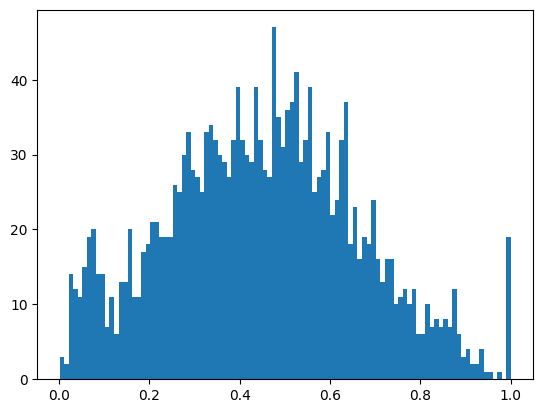

In [18]:

plt.hist([r['bleu-4'] for r in test_results], bins=100);
np.mean([r['bleu-4'] for r in test_results]), np.median([r['bleu-4'] for r in test_results])

In [19]:
dataset.set_split('val')
batch_generator = H.generate_nmt_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
batch_dict = next(batch_generator)

model = model.eval().to(args.device)
sampler = NMTSampler(vectorizer, model)
sampler.apply_to_batch(batch_dict)

In [20]:
all_results = []
for i in range(args.batch_size):
    all_results.append(sampler.get_ith_item(i, False))

In [21]:
top_results = [x for x in all_results if x['bleu-4']>0.1]
len(top_results)

61

/tmp/ipykernel_3118410/2852610811.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


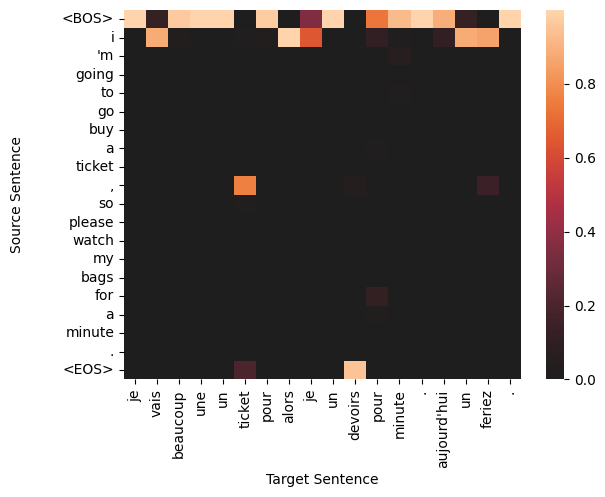

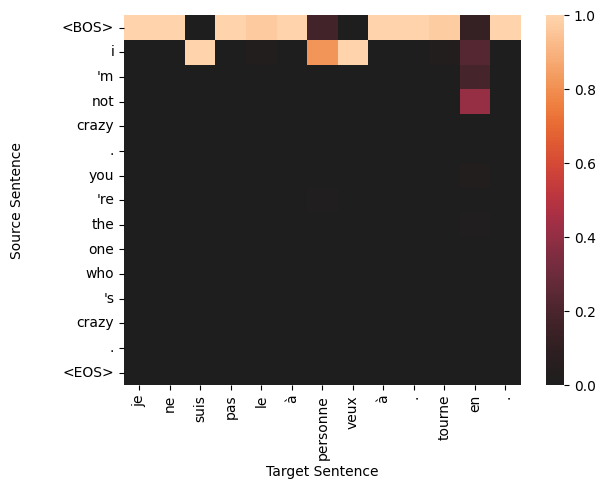

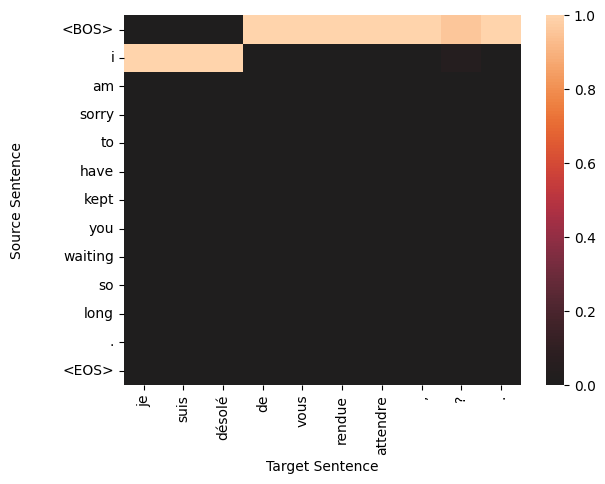

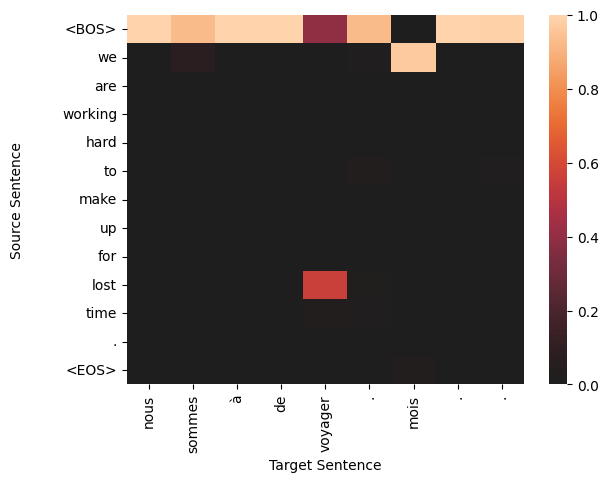

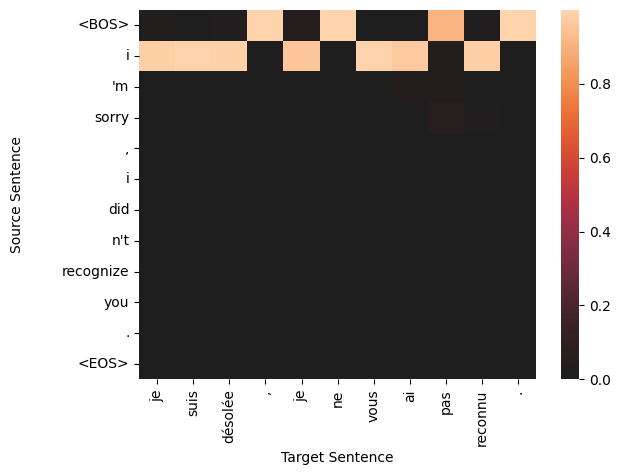

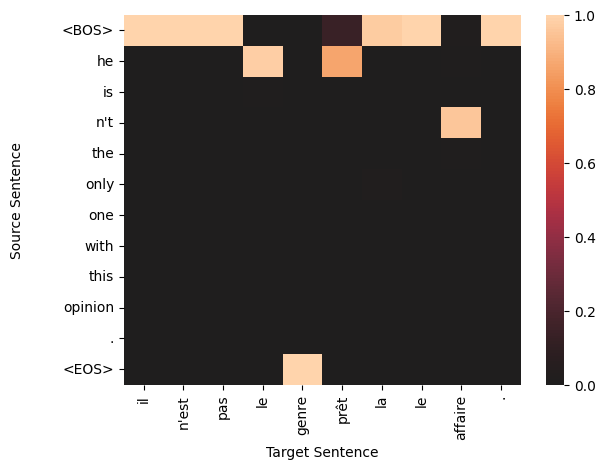

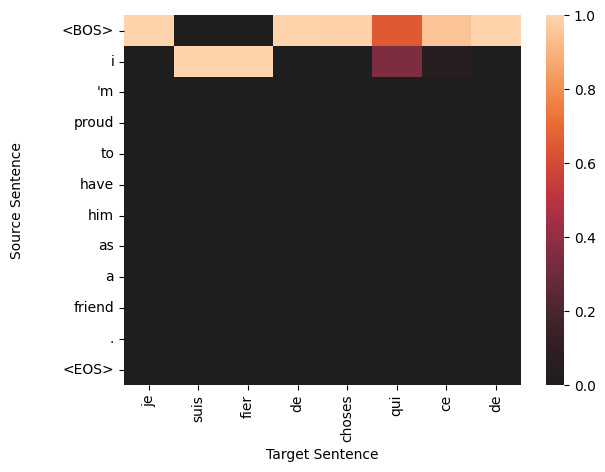

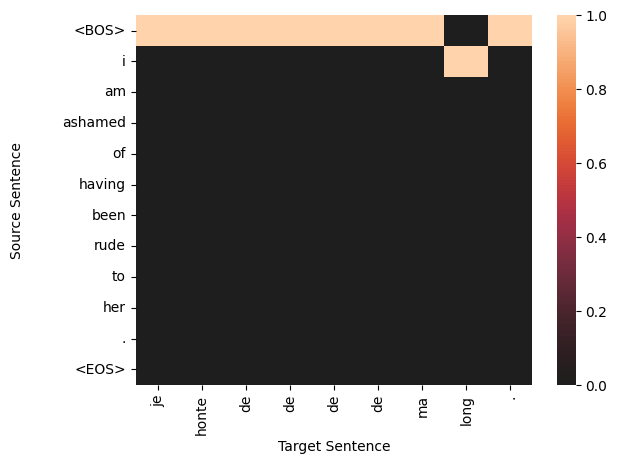

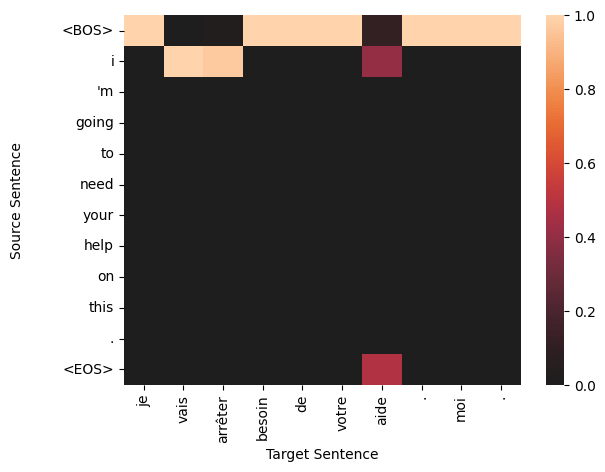

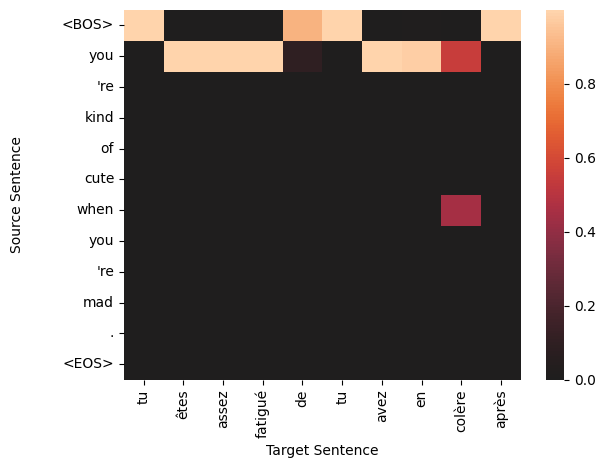

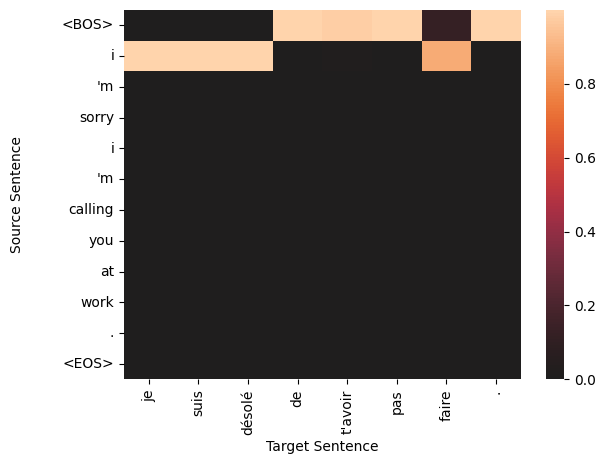

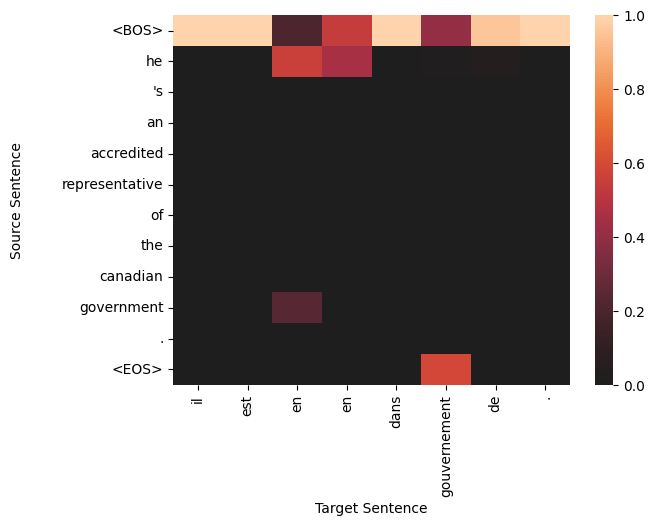

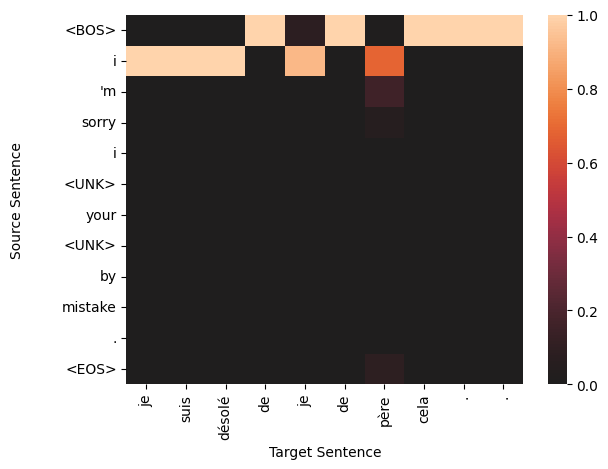

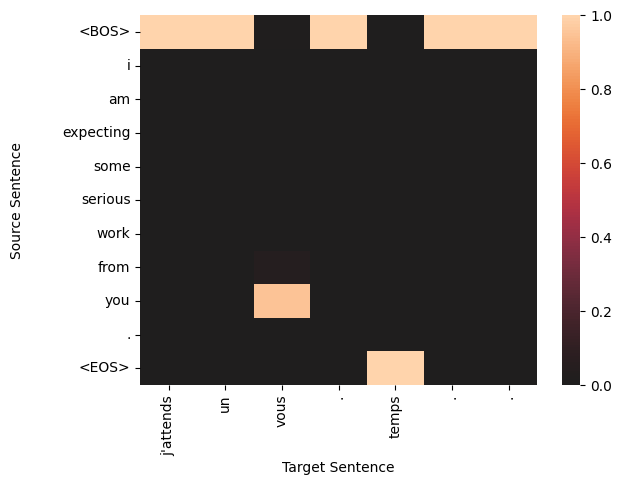

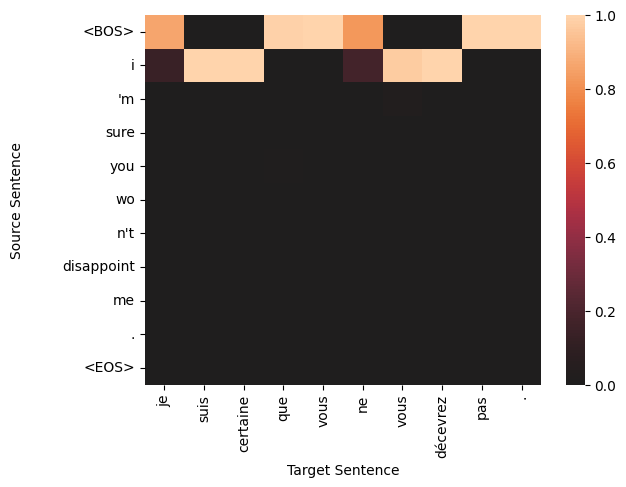

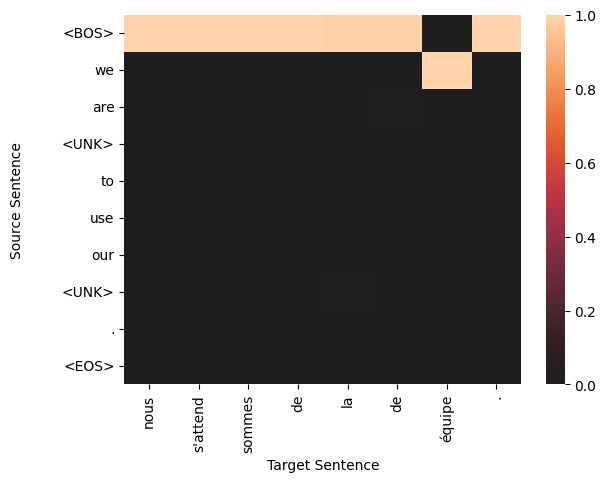

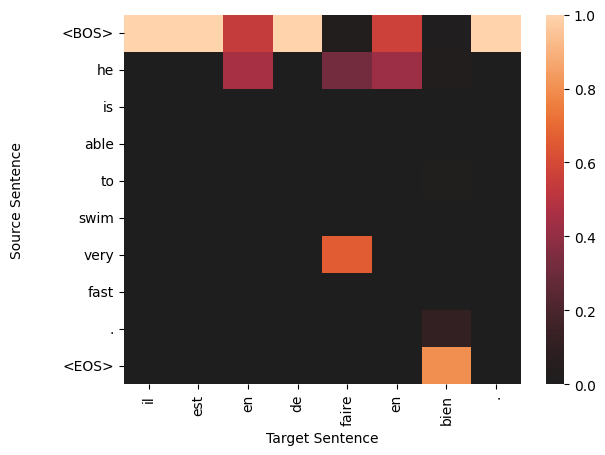

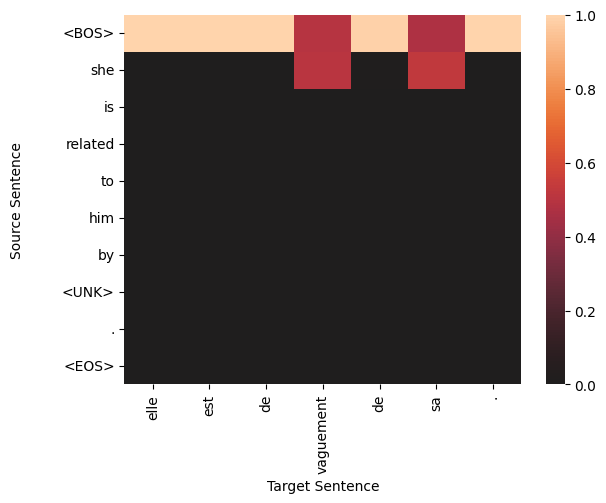

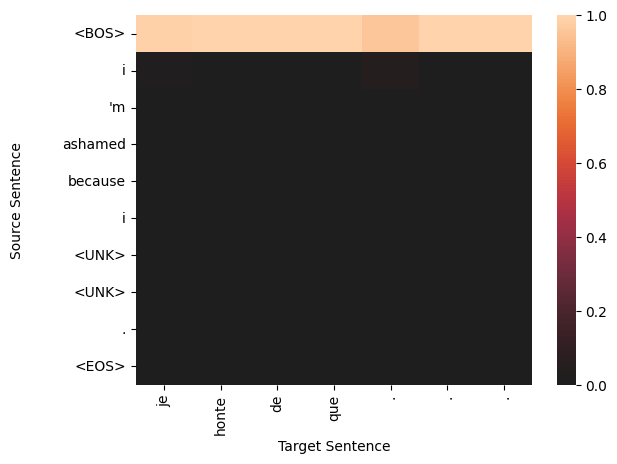

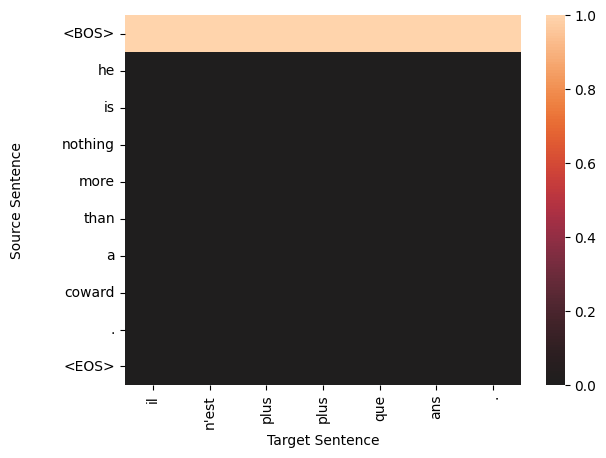

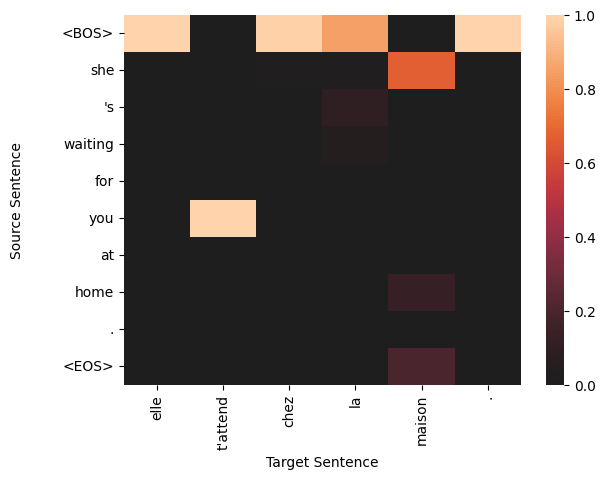

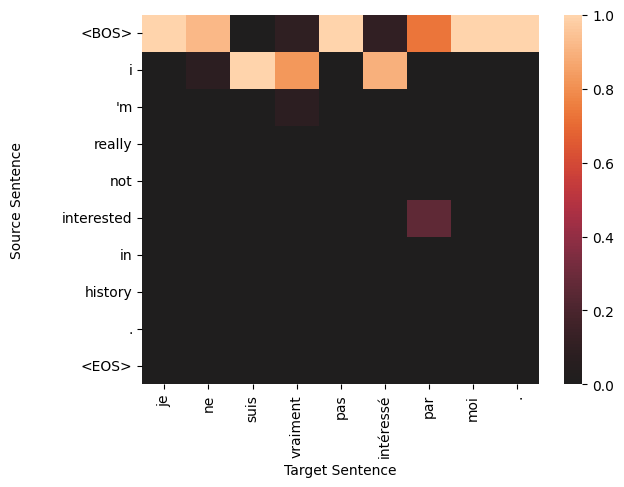

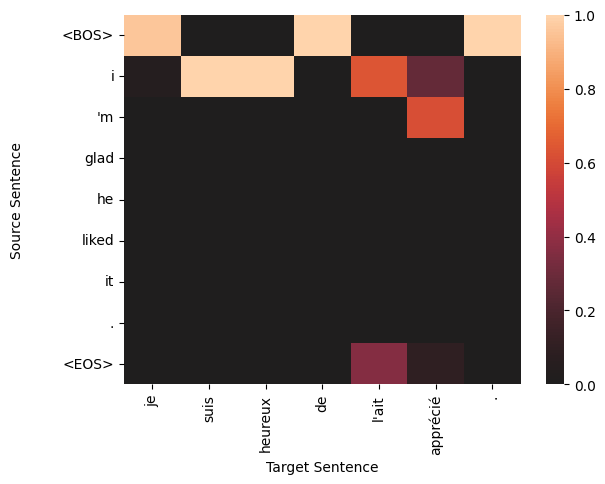

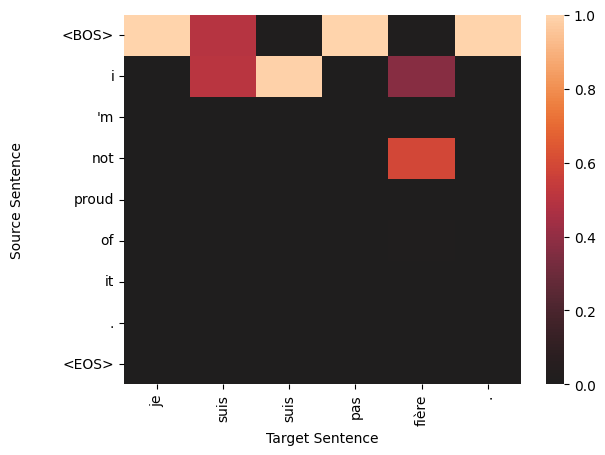

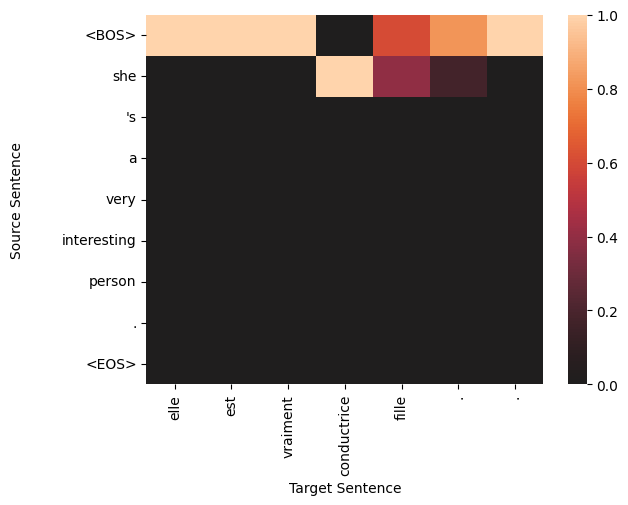

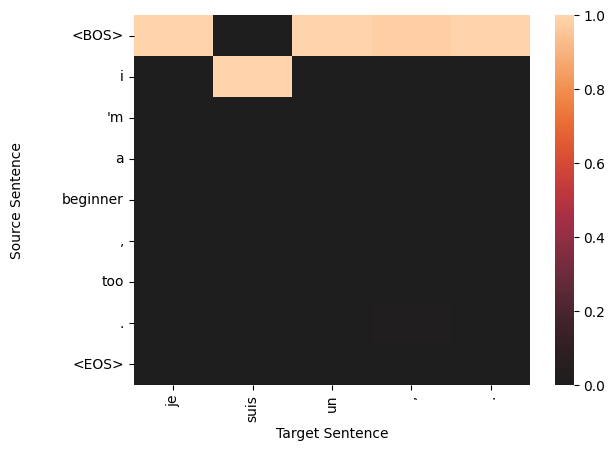

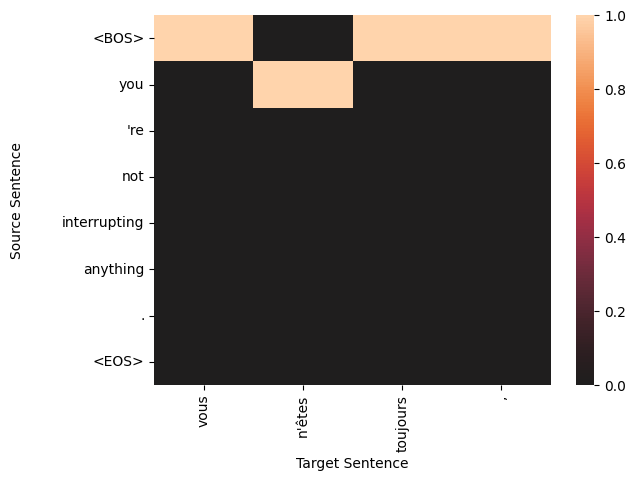

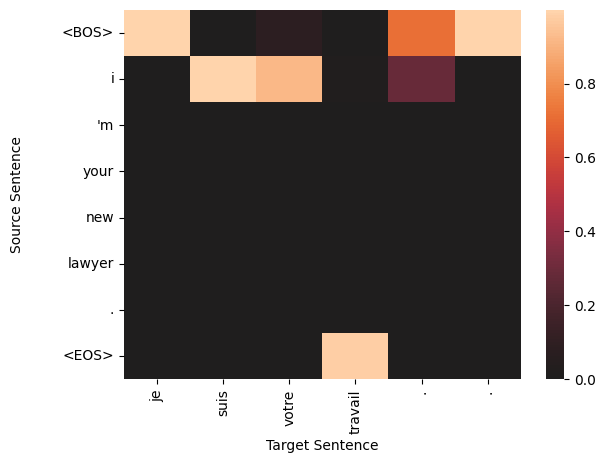

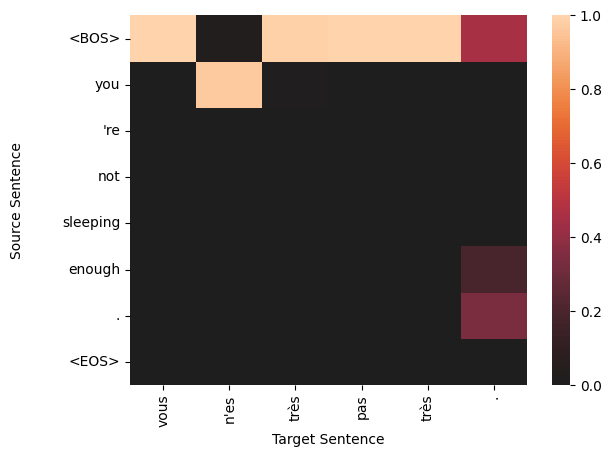

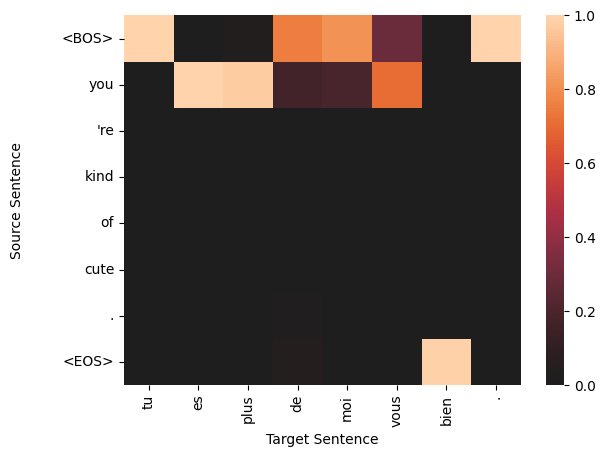

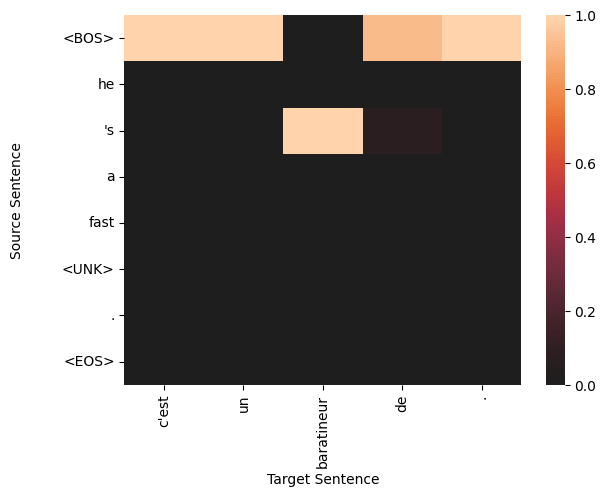

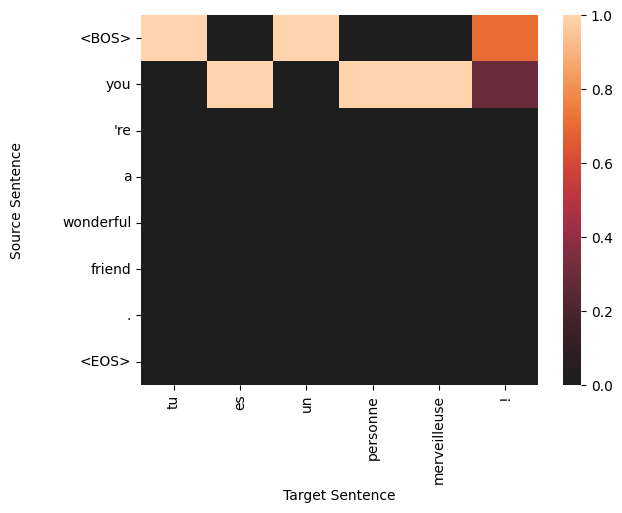

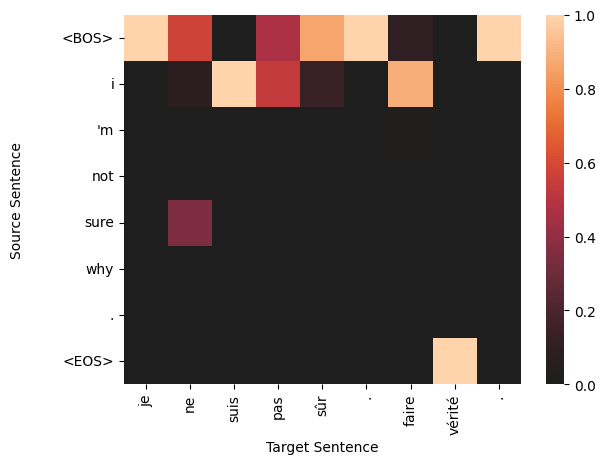

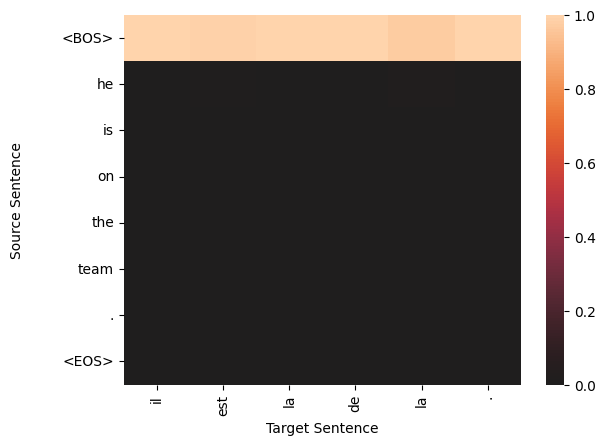

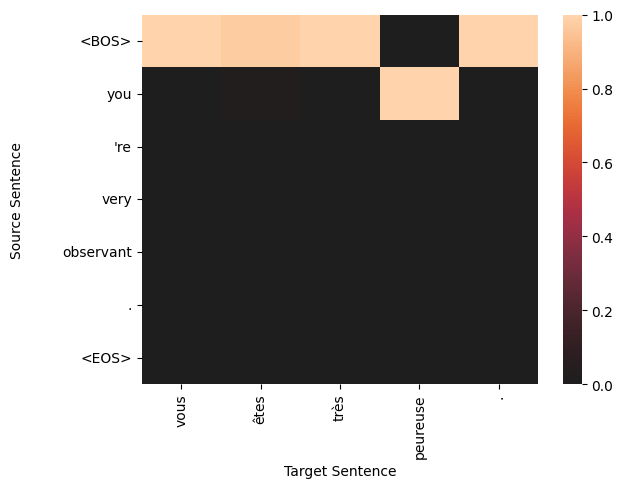

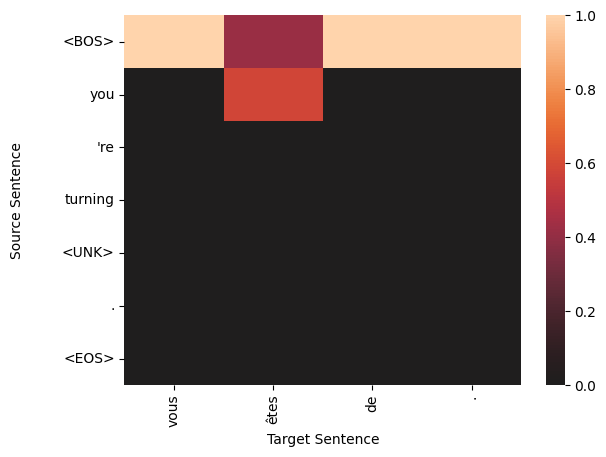

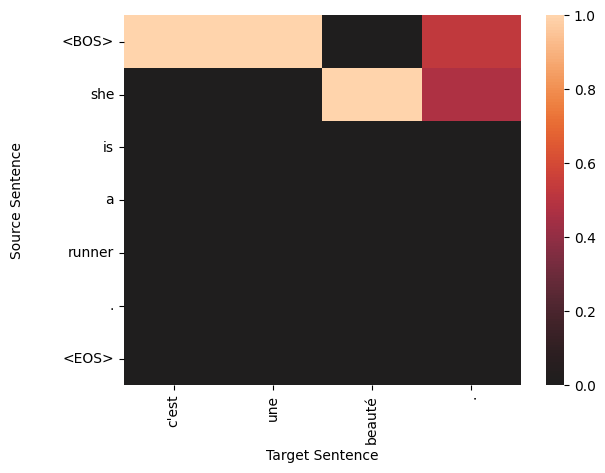

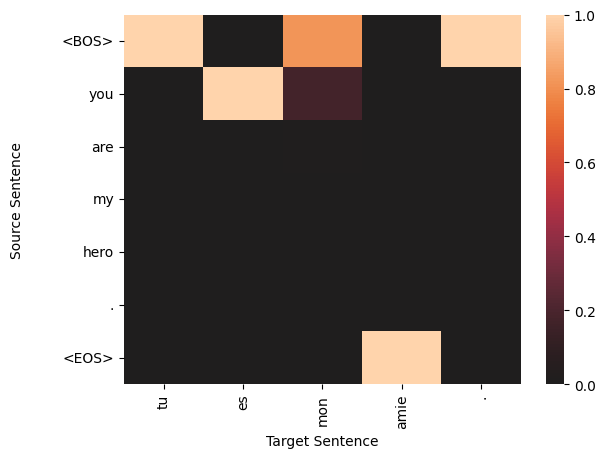

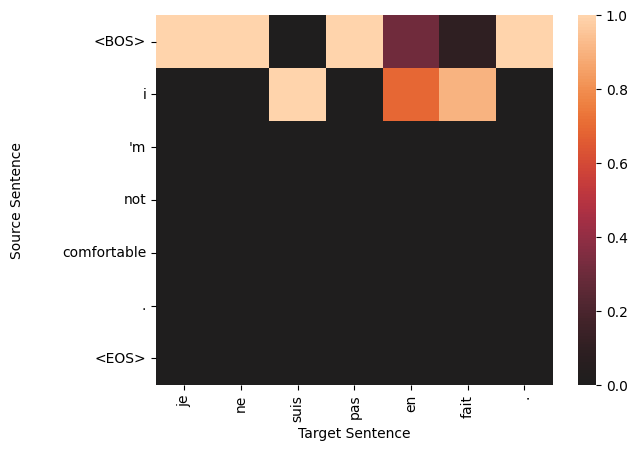

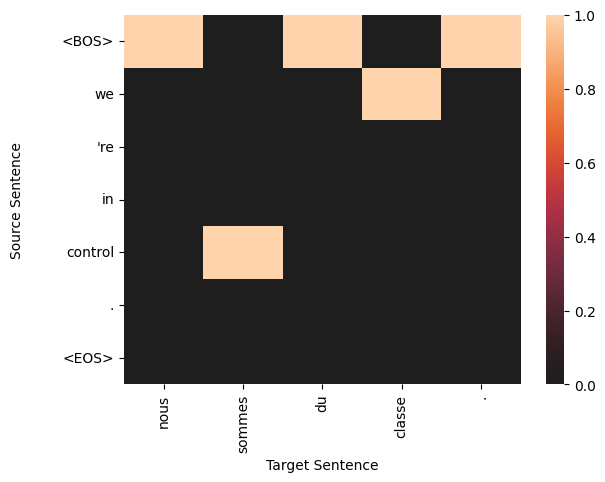

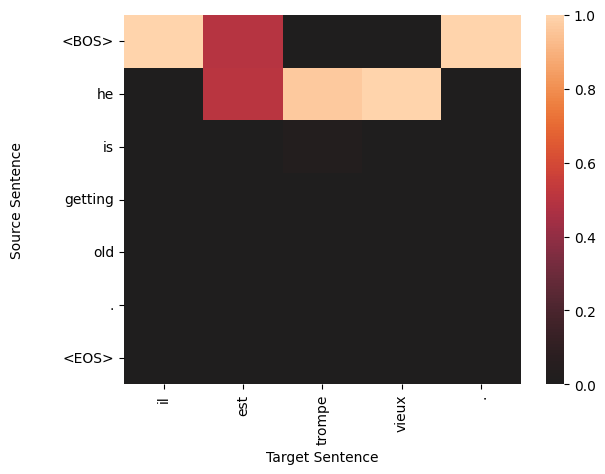

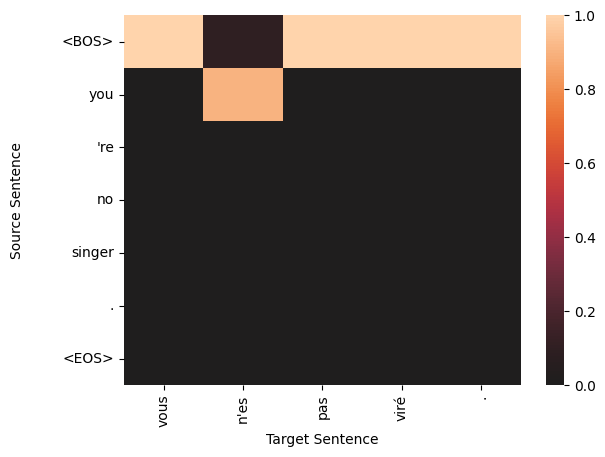

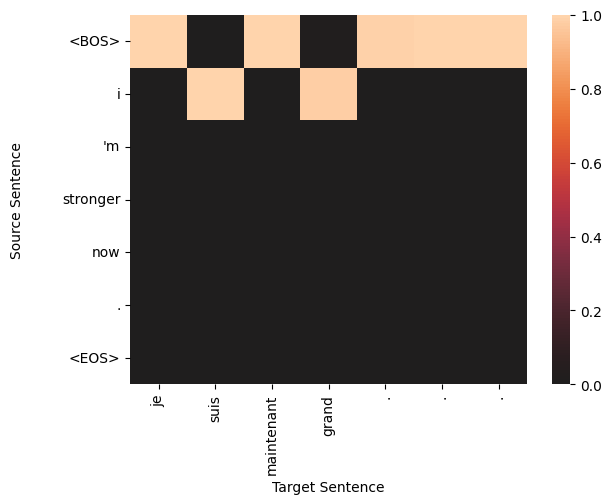

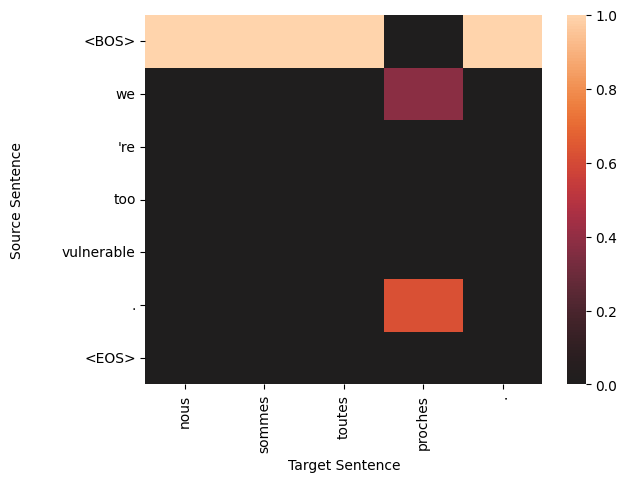

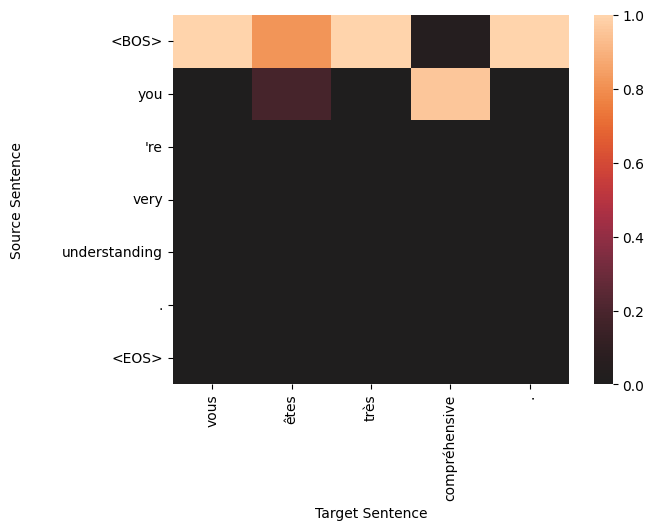

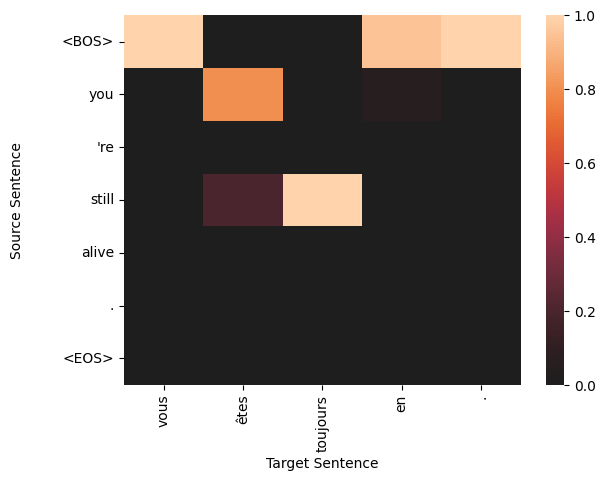

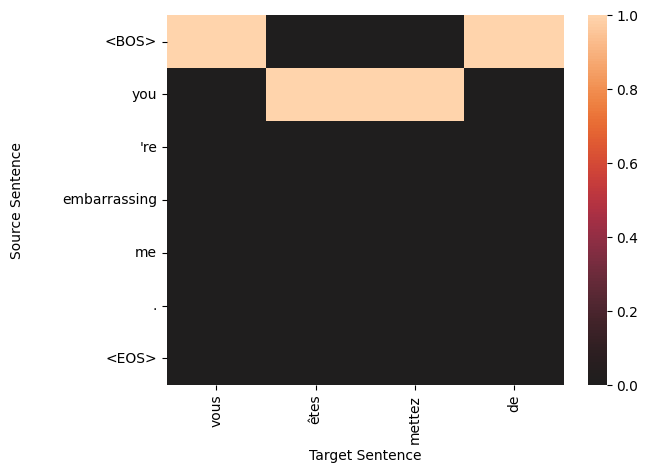

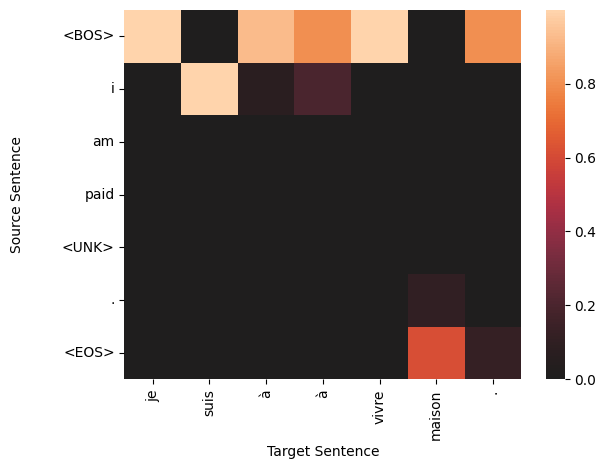

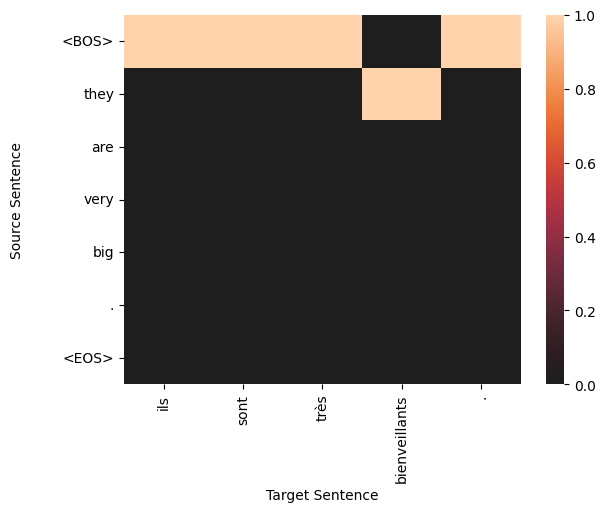

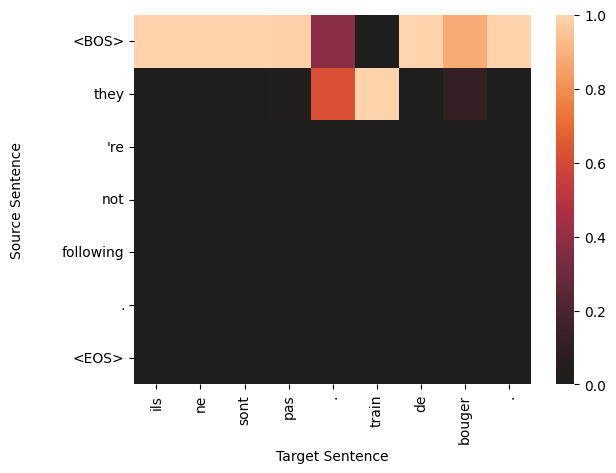

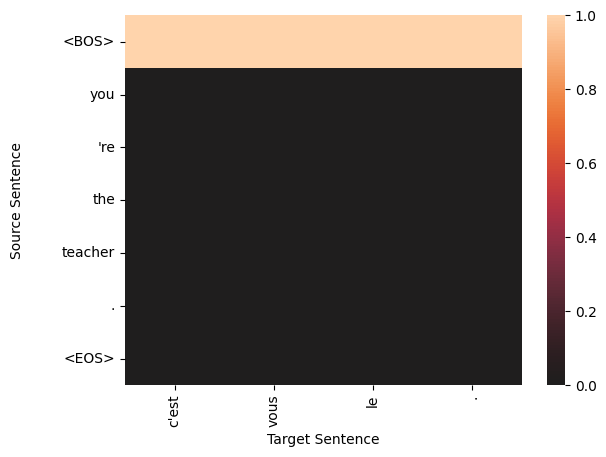

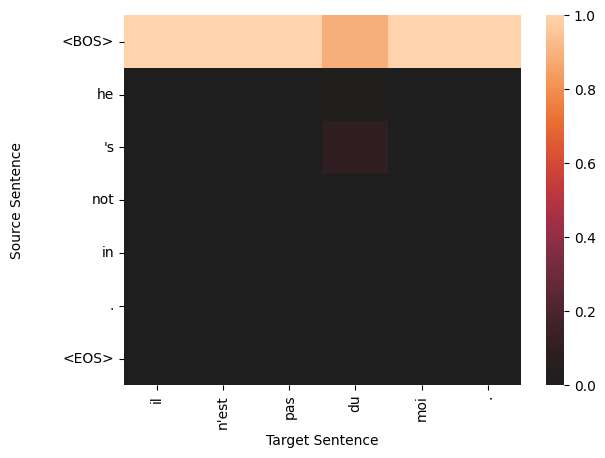

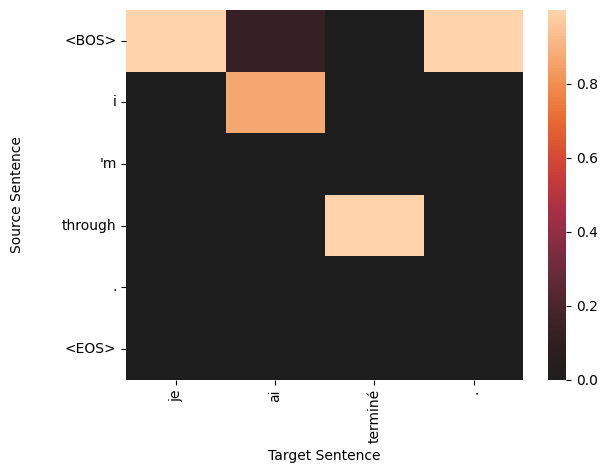

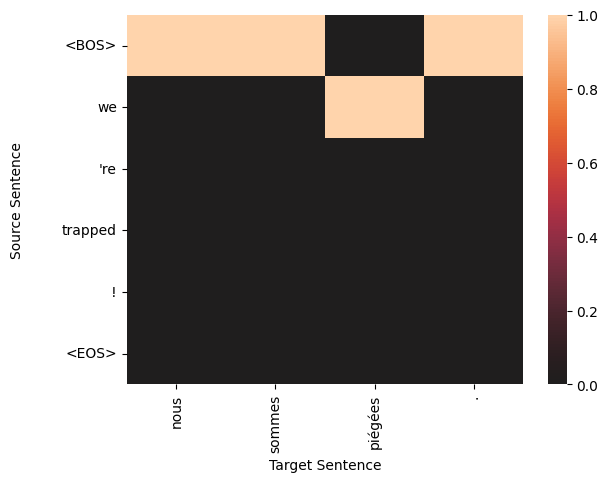

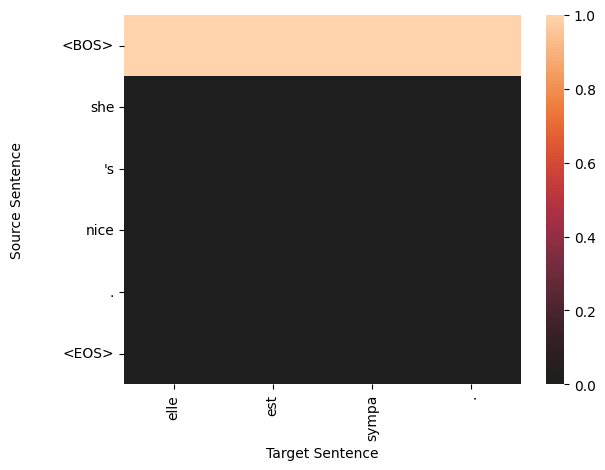

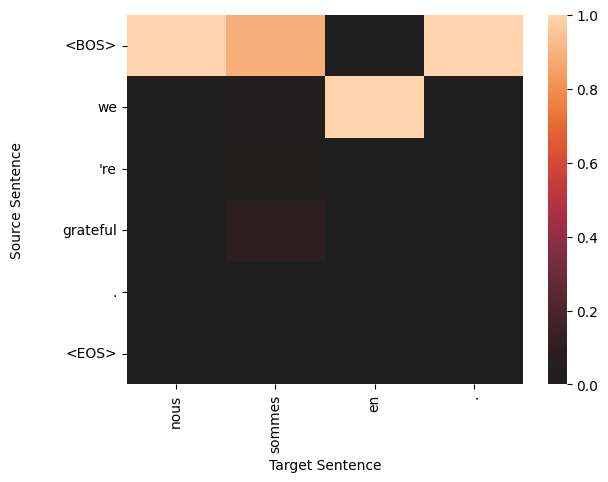

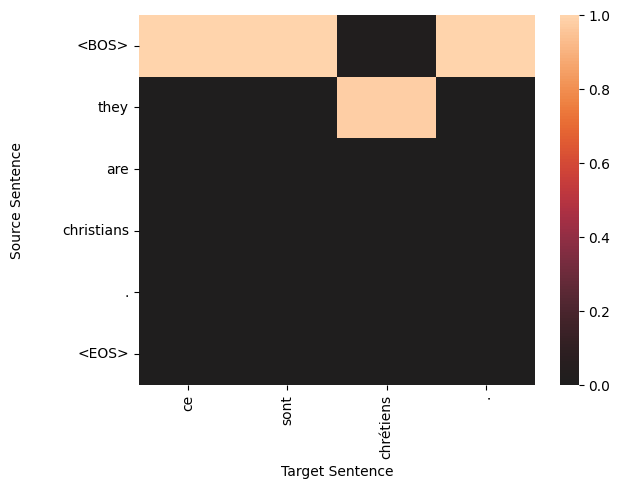

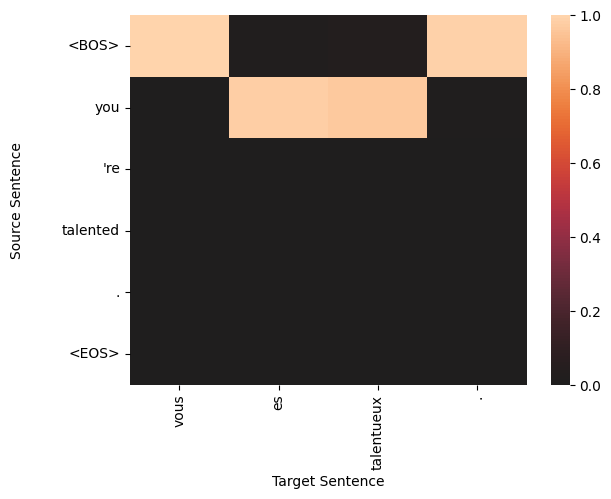

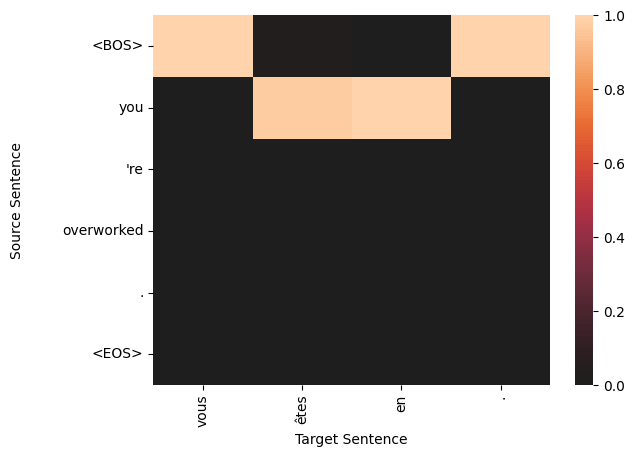

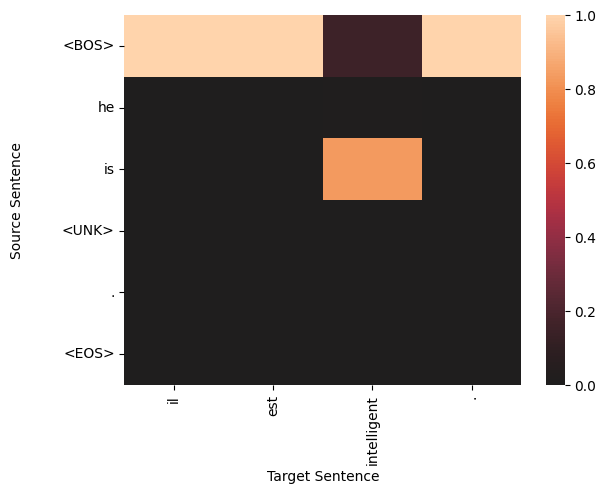

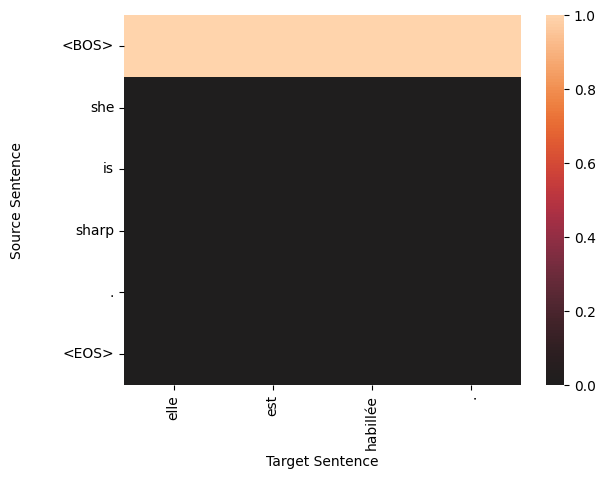

In [22]:
for sample in top_results:
    plt.figure()
    target_len = len(sample['sampled'])
    source_len = len(sample['source'])

    attention_matrix = sample['attention'][:target_len, :source_len+2].transpose()#[::-1]
    ax = sns.heatmap(attention_matrix, center=0.0)
    ylabs = ["<BOS>"]+sample['source']+["<EOS>"]
    #ylabs = sample['source']
    #ylabs = ylabs[::-1]
    ax.set_yticklabels(ylabs, rotation=0)
    ax.set_xticklabels(sample['sampled'], rotation=90)
    ax.set_xlabel("Target Sentence")
    ax.set_ylabel("Source Sentence\n\n")